In [1]:
import numpy as np
import utils
import planners
from models import CostFunction
import constants as c
import matplotlib.pyplot as plt
import time
import trajoptpy.math_utils as mu
from planners import feature_height, feature_orientation
import random
import itertools
%matplotlib inline

Using TensorFlow backend.


In [2]:
env, robot = utils.setup()

In [3]:
tq = utils.TrainingQueue(maxsize=10000)

In [ ]:
cf = CostFunction(robot, num_dofs=21, normalize=True)
#cf.load_model('./saves/mlp_allan_pretrained_happy/')
custom_cost = {'NN': planners.get_trajopt_cost(cf)}

In [8]:
robot.SetActiveDOFValues(c.configs[0])

In [6]:
def cost_height(x):
    val = -1. * feature_height(robot, x)
    return val
def cost_orientation(x):
    return -1 * feature_orientation(robot, x)

synthetic_costs = {
    'height': cost_height,
    'orientation': cost_orientation
}


def synthetic_cost(x):
    traj = x[:,:7]
    with env:
        traj_cost = utils.evaluate_costs(robot, traj, synthetic_costs)
    return traj_cost #+ utils.vel_cost(x)


def ee_traj_cost(x):
    x = x.reshape((10,7))
    ee_positions = np.stack([utils.get_ee_coords(robot, wp)
                             for wp in x])
    ee_cost = np.sum(np.square(np.diff(ee_positions, axis=0)))
    return ee_cost
    
ee_cost = {
    'ee_cost': ee_traj_cost
}

In [10]:
for start, goal in c.start_goal_pairs:
    linear_init = mu.linspace2d(start, goal, 10)
    new_trajs = [linear_init]
    for i in range(100):
        modified_init = utils.random_init_maker(linear_init)
        new_trajs.append(modified_init)
    random.shuffle(new_trajs)
    for traj in new_trajs:
        with env:
            wf = utils.world_space_featurizer(robot, traj)
        data = np.concatenate([traj, wf], axis=1)
        tq.add((data, synthetic_cost(traj)))

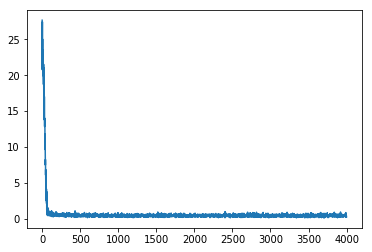

In [9]:
loss = []
for i in range(4000):
    x, y = zip(*tq.sample(num=10))
    x = np.stack(x)[:,:,7:]
    y = np.stack(y)
    loss.append(cf.train_cost(x, y))
plt.plot(loss)

In [20]:
for start, goal in c.start_goal_pairs:
    linear_init = mu.linspace2d(start, goal, 10)
    new_trajs = [linear_init]
    for i in range(10):
        modified_init = utils.random_init_maker(linear_init)
        new_trajs.append(modified_init)
    random.shuffle(new_trajs)
    new_data = []
    for traj in new_trajs:
        with env:
            wf = utils.world_space_featurizer(robot, traj)
        data = np.concatenate([traj, wf], axis=1)
        new_data.append((data, ee_traj_cost(traj)))
    for (xA, cA), (xB, cB) in itertools.combinations(new_data, 2):
        tq.add(((xA, 10), (xB, 10), cB < cA))

In [ ]:
loss = utils.train(cf, tq, epochs=20)
plt.plot(loss)

In [17]:
gan_q = utils.TrainingQueue(maxsize=100)
demo_q = utils.TrainingQueue(maxsize=100)

In [14]:
expert_D = []
for i, (start, goal) in enumerate(c.start_goal_pairs):
    robot.SetActiveDOFValues(start)
    with env:
        result = planners.trajopt_simple_plan(env, robot, goal, custom_costs=synthetic_costs, use_joint_vel=True)
    expert_D.append(result.GetTraj())

In [15]:
x = expert_D[0]
robot.SetActiveDOFValues(x[0])
with env:
    traj = utils.waypoints_to_traj(env, robot, x, 0.7, None)
robot.ExecuteTrajectory(traj)

RaveCreateInterface(RaveGetEnvironment(1),InterfaceType.trajectory,'GenericTrajectory')

In [18]:
for eD in expert_D:
    with env:
        data = utils.world_space_featurizer(robot, eD)
    data = np.concatenate([eD, data], axis=1)
    demo_q.add(data)

In [ ]:
for i, (start, goal) in enumerate(c.start_goal_pairs):
    start_time = time.time()
    robot.SetActiveDOFValues(start)
    with env:
        results = planners.trajopt_multi_plan(env, robot, goal, custom_traj_costs=custom_cost, num_inits=5, use_joint_vel=False)
        elapsed = time.time() - start_time
        print('Finished traj planning for iter {:d} in {:.2f}s'.format(i, elapsed))
    for result in results:
        wps = result.GetTraj()
        with env:
            data = utils.world_space_featurizer(robot, wps)
        data = np.concatenate([wps, data], axis=1)
        #label = utils.vel_cost(wps)
        gan_q.add(data)

In [18]:
for i in range(10 * len(gan_q)):
    fake = gan_q.sample()
    cf.train_gan_cost(fake[:,7:][None], [-1.])
    true = demo_q.sample()
    cf.train_gan_cost(true[:,7:][None], [1.])

In [6]:
pairs = [
    (0, 1),
    (1, 0),
    (2, 3),
    (3, 2),
    (6, 8),
    (8, 6)
]

In [7]:
trajs = {}
for start, goal in pairs:
    robot.SetActiveDOFValues(c.configs[start])
    with env:
        results_ee = planners.trajopt_simple_plan(env, robot, c.configs[goal], custom_traj_costs=custom_cost)
        traj = utils.waypoints_to_traj(env, robot, results_ee.GetTraj(), 0.7, None)
    trajs[(start, goal)] = traj

In [11]:
robot.SetActiveDOFValues(c.configs[6])

In [12]:
robot.ExecuteTrajectory(trajs[(6,8)])

RaveCreateInterface(RaveGetEnvironment(1),InterfaceType.trajectory,'GenericTrajectory')

In [7]:
robot.SetActiveDOFValues(c.configs[0])

with env:
    results_nn = planners.trajopt_simple_plan(env, robot, c.configs[1], custom_traj_costs=custom_cost)
    traj = utils.waypoints_to_traj(env, robot, results_nn.GetTraj(), 0.7, None)
#print(ee_traj_cost(results_nn.GetTraj()))
robot.ExecuteTrajectory(traj)

RaveCreateInterface(RaveGetEnvironment(1),InterfaceType.trajectory,'GenericTrajectory')

In [24]:
robot.SetActiveDOFValues(c.configs[0])
robot.ExecuteTrajectory(traj)

RaveCreateInterface(RaveGetEnvironment(1),InterfaceType.trajectory,'GenericTrajectory')

In [25]:
robot.SetActiveDOFValues(c.configs[0])

with env:
    results_default = planners.trajopt_simple_plan(env, robot, c.configs[1])
    traj = utils.waypoints_to_traj(env, robot, results_default.GetTraj(), 0.7, None)
print(ee_traj_cost(results_default.GetTraj()))
robot.ExecuteTrajectory(traj)

0.281132923048


RaveCreateInterface(RaveGetEnvironment(1),InterfaceType.trajectory,'GenericTrajectory')

In [27]:
cf.save_model('./saves/mlp_ee_cost_pretrained/')